<div style="color:#8b1538; font-size:32px;">Graphic representation using matplotlib and seaborn</div>

In [5]:
import ast
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sei.files.files as f
import sei.graphics.plot as plot
import sei.simulation.msprime as ms

<br>

# Common method

> Heatmap personnalization - xaxis and yaxis

In [2]:
def heatmap_axis(ax, xaxis, yaxis, cbar):
    """
    ax: matplotlib.axes.Axes
        ax to modify
    xaxis: str
        x-axis label
    yaxis: str
        y-axis label
    cbar: str
        colormap label
    """
    # Name
    names = ["Log10({})".format(xaxis), "Log10({})".format(yaxis)]  # (xaxis, yaxis)
    
    # x-axis
    plt.xticks(np.arange(64, step=7) + 0.5, labels=[round(ele, 2) for ele in np.arange(-4, 2.5, 0.7)], rotation='horizontal')
    plt.xlabel(names[0], fontsize="large")
    
    # y-axis
    ax.set_ylim(ax.get_ylim()[::-1])  # reverse y-axis
    plt.yticks(np.arange(64, step=7) + 0.5, labels=[round(ele, 2) for ele in np.arange(-3.5, 3, 0.7)])
    plt.ylabel(names[1], fontsize="large")
    
    # Set colorbar label & font size
    ax.figure.axes[-1].set_ylabel(cbar, fontsize="large")

<br>

# SFS shape verification

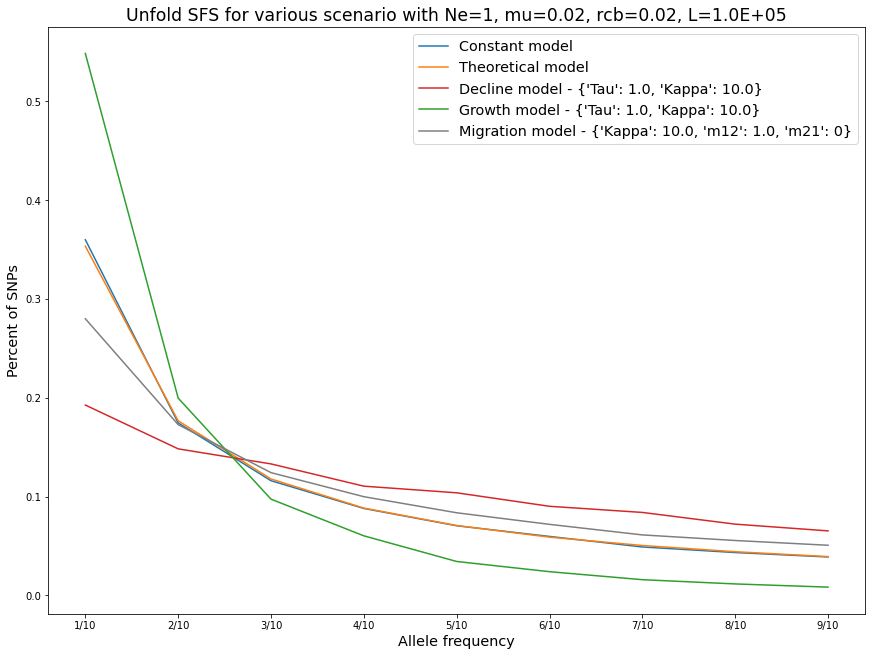

In [7]:
data = f.load_sfs()
plot.plot_sfs(data)

**Constant model**. Constant size population model. **Theoritical model**. Theoritical SFS for any constant population. **Decline model**. sudden decline of an ancestral population of size Ne\*kappa to size Ne at a time tau in the past. **Growth model**. sudden growth of an ancestral population of size Ne to size Ne\*kappa at a time tau in the past. **Migration model**. migration model of two populations pop1 and pop2 of size Ne and Ne\*kappa respectively. m12 is the migration rate into 1 from 2 and m21 is the migration rate into 2 from 1 (by default m21 s 0)

<br>

# SNPs distribution

> Load data

In [7]:
def load_data(model, path_data):
    data = pd.read_json(path_or_buf="{}SFS_{}-all.json".format(path_data, model), typ='frame')
    
    return data

<br>

> Data pre-processing

In [7]:
def data_preprocessing(sfs):
    """
    Pre processing for the plot.
    """
    # New pandas DataFrame
    data = pd.DataFrame()
    
    # Compute log10 of parameters - either (tau, kappa) or (m12, kappa)
    keys = sfs['Parameters'][0].keys()
    names = []
    for key in keys:
        if key in ['Tau', 'Kappa', 'm12']:
            names.append(key)
            data[key] = sfs['Parameters'].apply(lambda param: param[key])
    
    # Compute mean(SNPs)
    data['SNPs'] = sfs['SNPs'].apply(lambda snp: np.log10(np.mean(snp)))

    return data.pivot(names[1], names[0], 'SNPs')

<br>

> Plot data

In [10]:
def plot_snp_distribution(data, model):
    # Set-up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')

    # Plot
    ax = sns.heatmap(data, cmap="coolwarm")
    
    # Heatmap x and y-axis personnalization
    heatmap_axis(ax=ax, xaxis=data.columns.name, yaxis=data.index.name, cbar="SNPs - log scale")
    
    # Title
    title = "SNPs distribution in terms of {} & {} - {} model".format(data.columns.name, data.index.name, model)
    plt.title(title, fontsize="x-large", color="#8b1538")
    
    plt.show()

<br>

### SNPs distribution - decline model

> By default

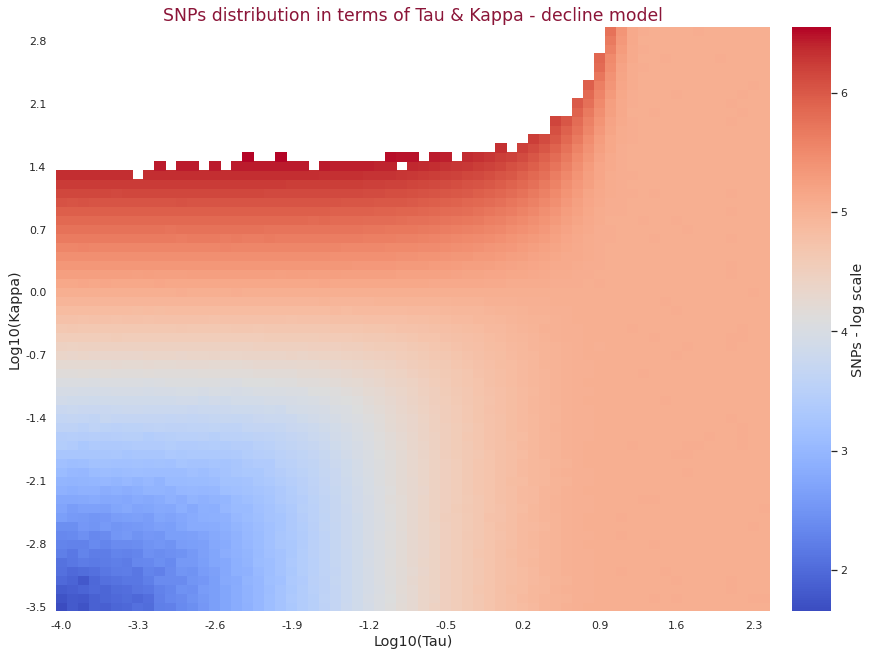

In [11]:
model, path_data = "decline", "./Data/Msprime/snp_distribution/sfs_decline-default/"
data = data_preprocessing(load_data(model, path_data))
plot_snp_distribution(data, model)

Il y a une grande disparité dans le nombre de SNPs en fonction de tau & kappa.

<br>

> About 100 000 SNPs for each observed SFS

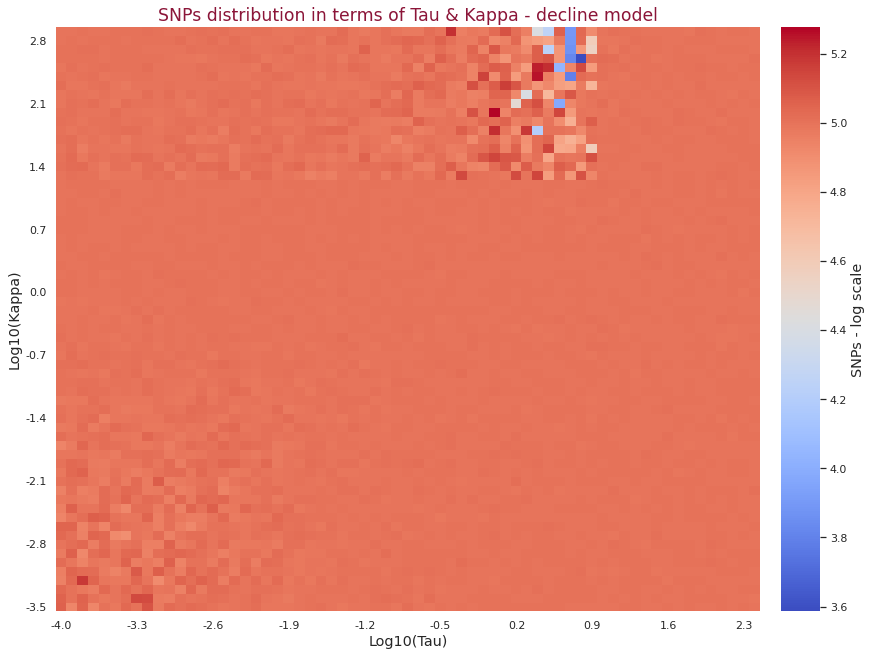

In [12]:
model, path_data = "decline", "./Data/Msprime/snp_distribution/sfs_decline/"
data = data_preprocessing(load_data(model, path_data))
plot_snp_distribution(data, model)

<br>

# Dadi inference

Benchmark of dadi inference by weighted square distance & log-likelihood ratio test

<div style="color: #8b1538; font-size: 22px">1. Weighted square distance</div><br>

The weighted square distance $\large{d^2}$ is:

1. Between the observed SFS $\large{\eta^{obs}}$ and the predicted SFS by model M1 $\large{\eta^{model}}$

\begin{equation}
\Large{ d^2(\eta^{model}, \eta^{obs}) = \sum_{i=1}^{n}{\frac{(\eta^{model}_i - \eta^{obs}_i)^2}{\eta^{model}_i }} }
\end{equation}

2. Between the inferred SFS of two models ($\large{\eta^{m2}}$ & $\large{\eta^{m1}}$)

\begin{equation}
\Large{ d^2(\eta^{m0}, \eta^{m1}) = \sum_{i=1}^{n}{\frac{(\eta^{m0}_i - \eta^{m1}_i)^2}{ (\eta^{m0}_i + \eta^{m1}_i) / 2 }} }
\end{equation}

Start the sum from 2 to ignore singletion (i=2).

<div class="alert alert-warning">Each SFS must be normalized for comparison</div>

<br>

> Pre-processing data (SFS normalization) and compute the weighted square distance

In [8]:
def normalization(sfs):
    """
    Return a normalized sfs
    """
    return [ele / sum(sfs) for ele in sfs]


def compute_weighted_square_distance(sfs):
    if "Observed" in sfs.keys():
        d2 = [
            np.power(eta_model - eta_obs, 2) / eta_model for eta_obs, eta_model in zip(sfs['Observed'], sfs['Model'])
        ]
    else:
        d2 = [
            np.power(eta_m0 - eta_m1, 2) / (np.mean([eta_m0, eta_m1])) for eta_m0, eta_m1 in zip(sfs['M0'], sfs['M1'])
        ]
    return sum(d2)


def data_weighted_square_distance(data):
    df = pd.DataFrame()
    
    # 1. Compute log 10 of tau & kappa
    for key in data['Parameters'][0].keys():
        if key in ['Tau', 'm12', 'Kappa']:
            df[key] = data['Parameters'].apply(lambda ele: np.log10(ele[key]))
    
    # 2. Normalization
    data['SFS observed'] = data['SFS observed'].apply(lambda x: [normalization(ele[1:-1]) for ele in x])
    
    data['M0'] = data['M0'].apply(
        lambda x: {k: ([normalization(ele) for ele in v] if k == 'SFS' else v) for k, v in x.items()}
    )
    data['M1'] = data['M1'].apply(
        lambda x: {k: ([normalization(ele) for ele in v] if k == 'SFS' else v) for k, v in x.items()}
    )
    
    # 2. Compute weighted square distance
    d2_observed_inferred = {}  # d2 between the observed SFS and inferred one with M1
    d2_models = {}  # d2 between the inferred SFS of two models (M0 & M1)
    
    for i, row in data.iterrows():

        # Iterate over all the normalized observed SFS & normalized inferred SFS with M1
        tmp = []
        for sfs_observed, sfs_inferred in zip(row['SFS observed'], row['M1']['SFS']):
            tmp.append(compute_weighted_square_distance({'Observed': sfs_observed, 'Model': sfs_inferred}))
        d2_observed_inferred[i] = np.mean(tmp)
            
        # Iterate over all the normalized inferred SFS with M0 & M1
        tmp = []
        for sfs_m0, sfs_m1 in zip(row['M0']['SFS'], row['M1']['SFS']):
            tmp.append(compute_weighted_square_distance({'M0': sfs_m0, 'M1': sfs_m1}))
        d2_models[i] = np.mean(tmp)
        
    # Add new columns to DataFrame data from dictionary
    df['d2 observed inferred'] = pd.Series(d2_observed_inferred)
    df['d2 models'] = pd.Series(d2_models)
            
    return df

<br>

> Plot the weighted square distance - Heatmap

In [9]:
def plot_weighted_square_distance_heatmap(data, d2, models):
    # Set-up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')
    
    # Data
    df = pd.DataFrame()
    df[data.columns[1]] = data[data.columns[1]]
    df[data.columns[0]] = data[data.columns[0]]    
    df[d2] = data[d2].apply(lambda distance: np.log10(distance))
    
    df = df.pivot(index=df.columns[0], columns=df.columns[1], values=d2)
    
    # Plot
    ax = sns.heatmap(df, cmap="coolwarm")
    
    # Heatmap x and y-axis personnalization
    heatmap_axis(ax=ax, xaxis=df.columns.name, yaxis=df.index.name, cbar='Weighted square distance - log scale')
    
    # Title
    title = "Weighted square d2 of {} & {} models".format(models[0], models[1])
    plt.title(title, fontsize="x-large", color="#8b1538")
    
    plt.plot()

<br>

> Plot the weighted square distance - fixed tau or kappa

In [10]:
def plot_weighted_square_distance(data, key, labels, suptitle):
    d2 = ['d2 observed inferred', 'd2 models']
    title = [
        'd2 between the observed SFS and inferred one with M1', 
        'd2 between the inferred SFS of two models (M0 & M1)'
    ]
    
    # Set-up plot
    sns.set_theme(style='whitegrid')
    
    # Sub-plots
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))  # Figsize: (width, height)
    
    # Plot
    for i, ax in enumerate(axs):  # Iterate through subplot
        
        for j, dataframe in enumerate(data):  # Iterate through DataFrame in data
            # Data
            df = pd.DataFrame()
            df[key] = dataframe[key]   
            df[d2[i]] = dataframe[d2[i]].apply(lambda distance: np.log10(distance))
            
            # Plot
            _ = sns.lineplot(x=key, y=d2[i], data=df, label=labels[j], ax=ax)
        
        ax.legend(fontsize="large")
        ax.set_title(title[i], fontsize="large")
        
    plt.suptitle(suptitle, fontsize="x-large")
    
    plt.plot()

<br>

<div style="color: #8b1538; font-size: 22px">2. Log-likelihood ratio test</div><br>

The likelihood ratio test assess the godness fit of two model. It's allow you to test wheter adding parameters to models significantly increase the likelihood the model.

**Models**

* M0 a n0-parameter model - the model with less parameters

* M1 a n1-parameter model - the model with more parameters

with n0 < n1 (number of parameters)

<br>

**Hypothesis**

* H0 the null hypothesis - adding the parameter(s) does not significantly increase the likelihood of the model

* H1 the alternative hypothesis - adding the parameter(s) significantly increase the likelihood of the model

<br>

**Decision rule**

* If p-value >= $\alpha$ then the test is insignificant and do not reject of H0

* If p-value < $\alpha$ then the test is significant and reject of H0

with $\alpha = 0.05$

<br>

**Degrees of freedom**

The difference in the number of parameters between M0 and M1, i.e. n1 - n0

<br>

> Data pre-processing

In [11]:
def data_preprocessing_heatmap(data):
    keys = data['Parameters'][0].keys()
    
    # Compute log10
    name = []
    for key in keys:
        if key in ['Tau', 'Kappa', 'm12']:
            name.append(key)
            data[key] = data['Parameters'].apply(lambda ele: np.log10(ele[key]))
    
    return data.pivot(name[0], name[1], 'Positive hit')

<br>

> Plot log-likelihood ratio test - heatmap

In [12]:
def plot_inference_dadi_heatmap(data):
    # Set-up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')
    
    # Pre-processing data
    df = pd.DataFrame()

    for key in data['Parameters'][0].keys():
        df[key] = data['Parameters'].apply(lambda param: np.log10(param[key]))  # Log10 of parameters (tau, kappa) or (m12, kappa)

    df['Positive hit'] = data['Positive hit']  # Add positive hit columns to df
    
    df = df.pivot(df.columns[1], df.columns[0], 'Positive hit')  # Pivot
    
    # Plot
    ax = sns.heatmap(df, cmap="coolwarm")
    
    # Heatmap x and y-axis personnalization
    heatmap_axis(ax=ax, xaxis=df.columns.name, yaxis=df.index.name, cbar='Significant log-likelihood ratio test out of 100 tests')
    
    # Title
    title = "Log likelihood ratio test for various tau & kappa with p.value = 0.05"
    plt.title(title, fontsize="x-large", color="#8b1538")
    
    plt.plot()

<br>

> Plot log-likelihood ratio test - fixed tau or kappa

In [13]:
def plot_inference_dadi(data, key, labels, suptitle):
    # Set-up plot
    plt.figure(figsize=(10,8), constrained_layout=True)
    sns.set_theme(style='whitegrid')

    # Plot
    for i, df in enumerate(data):
        df[key] = df['Parameters'].apply(lambda param: np.log10(param[key]))
        ax = sns.lineplot(x=key, y='Positive hit', data=df, label=labels[i])
    ax.legend(fontsize="large")
    
    plt.suptitle(suptitle, fontsize="x-large")
    
    plt.plot()

<br>

### Heatmap - sudden decline & growth model 

> Load data

In [14]:
data_all = f.export_inference_files('decline', 'all')
data_wsd = data_weighted_square_distance(data_all)

<br>

> Weighted square distance - observed SFS and inferred models

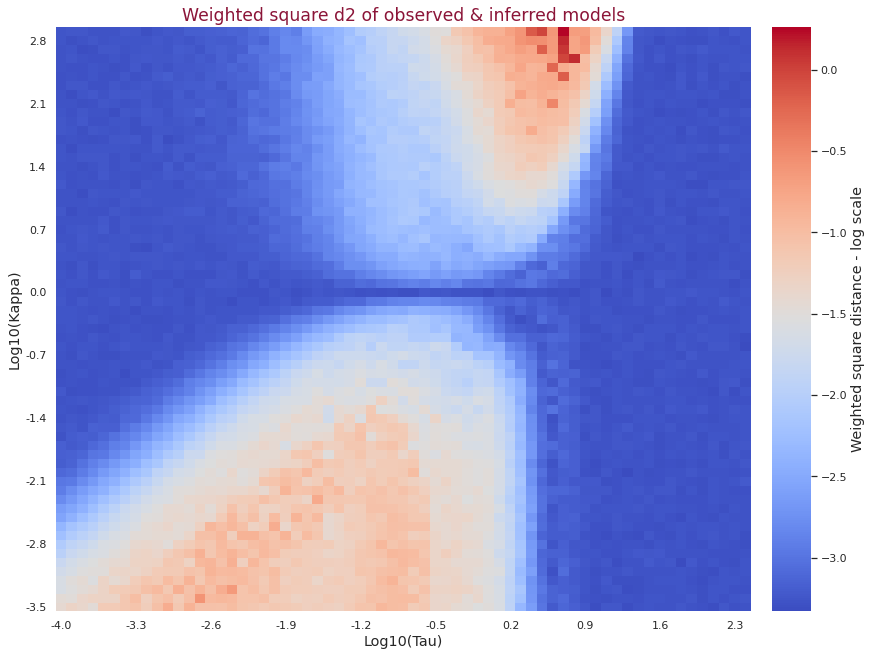

In [21]:
plot_weighted_square_distance_heatmap(data_wsd, 'd2 observed inferred', ['observed', 'inferred'])

<br>

> Weighted square distance - M0 & M1

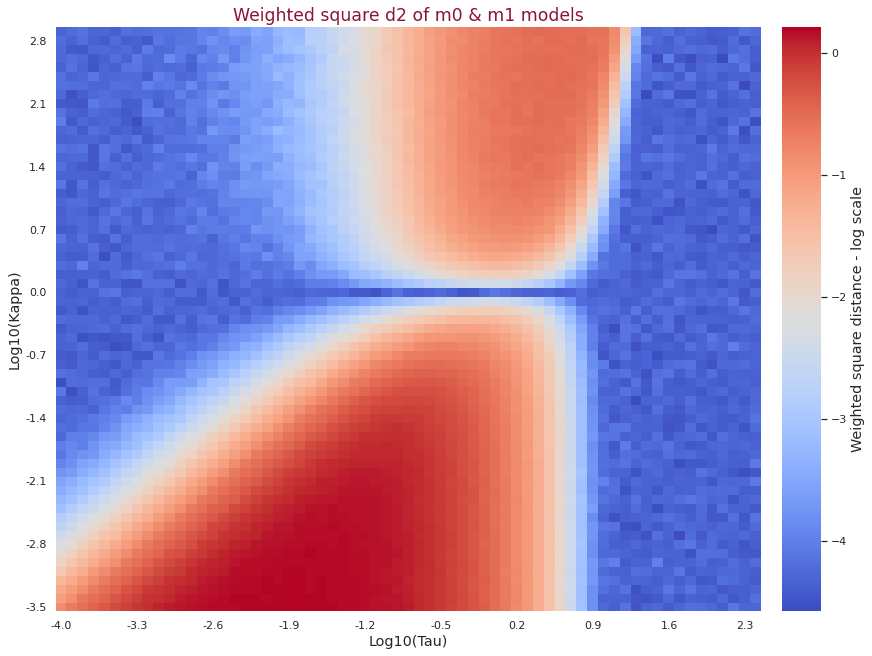

In [22]:
plot_weighted_square_distance_heatmap(data_wsd, 'd2 models', ['m0', 'm1'])

<br>

> Log-likelihood ratio test

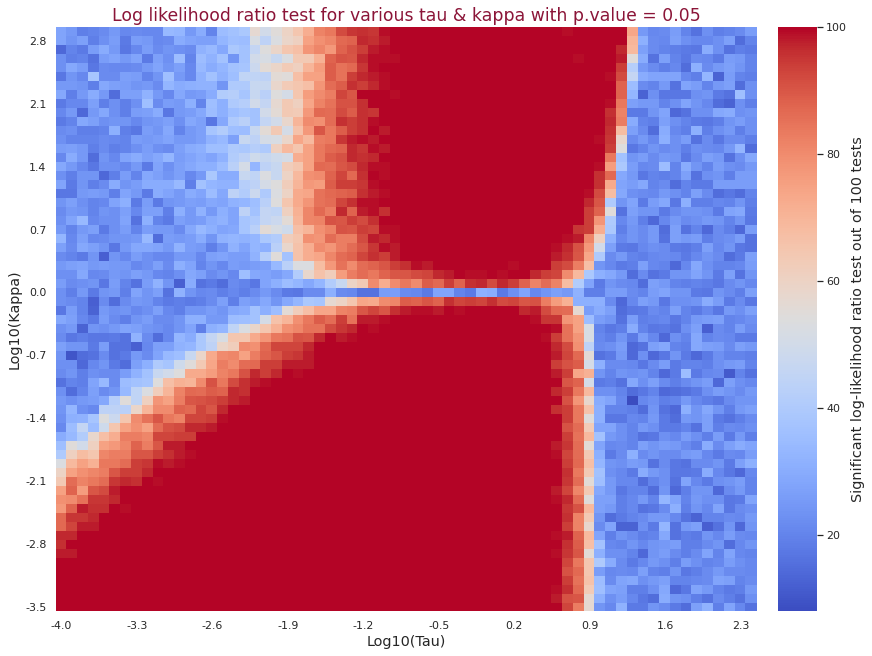

In [57]:
plot_inference_dadi_heatmap(data_all)

<br>

### Fixed kappa - sudden decline & growth model 

> Load data

In [24]:
data_2 = f.export_inference_files('decline', 'kappa', 2)
data_10 = f.export_inference_files('decline', 'kappa', 10)

data_wsd_kappa = [data_weighted_square_distance(data_2), data_weighted_square_distance(data_10)]

<br>

> Weighted square distance

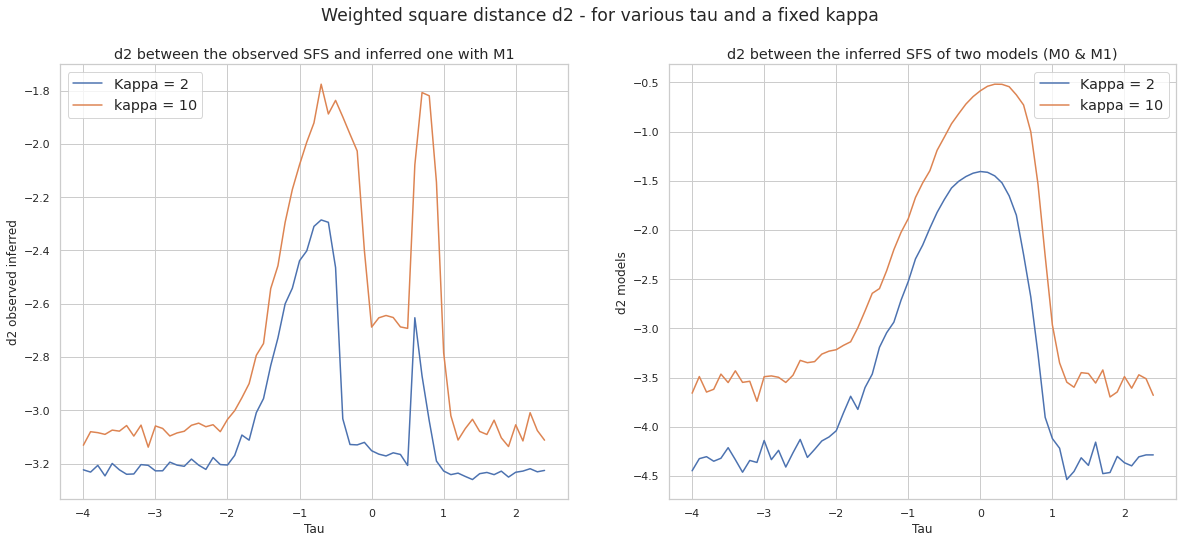

In [25]:
plot_weighted_square_distance(
    data=data_wsd_kappa, key="Tau", 
    labels=['Kappa = 2', 'kappa = 10'],
    suptitle="Weighted square distance d2 - for various tau and a fixed kappa")

In [102]:
data_wsd.sort_values(by=['Tau'], ascending=True)

,Tau,Kappa,d2 observed inferred,d2 models
378,-4.0,-2.2,0.001228,0.000390
2962,-4.0,-2.1,0.001058,0.000292
1484,-4.0,2.1,0.000535,0.000038
4167,-4.0,-2.0,0.000800,0.000178
67,-4.0,1.9,0.000581,0.000096
...,...,...,...,...
3641,2.4,-1.0,0.000516,0.000043
176,2.4,-0.9,0.000540,0.000045
1535,2.4,2.4,0.000512,0.000056
1005,2.4,-0.7,0.000563,0.000049


In [118]:
np.power(10, 0.3)

1.9952623149688795

In [121]:
for _, row in data_wsd.sort_values(by=['Tau'], ascending=True).iterrows():
    if round(row['Kappa'], 2) == 0.3:
        if round(row['Tau'], 2) in [round(ele, 2) for ele in np.arange(-0.7, 2, 0.1)]:
            print("{:>4}: {}".format(round(row['Tau'], 2), row['d2 observed inferred']))

-0.7: 0.0036321084438307076
-0.6: 0.0037926763411370744
-0.5: 0.0027665106606378576
-0.4: 0.0039479131915638324
-0.3: 0.0031967944554021506
-0.2: 0.003528126122724789
-0.1: 0.0029033555938643494
 0.0: 0.00256336328036144
 0.1: 0.0022539552280688604
 0.2: 0.0021379262966994246
 0.3: 0.0013103316342128913
 0.4: 0.0008162702140843484
 0.5: 0.0006964517376782289
 0.6: 0.0012678922993425254
 0.7: 0.0007892003928019854
 0.8: 0.0007608629671671602
 0.9: 0.0005738262323145187
 1.0: 0.0005814873195873075
 1.1: 0.0005268935305618798
 1.2: 0.0005735153575790544
 1.3: 0.0005219253367207563
 1.4: 0.0005109492639070185
 1.5: 0.0005392288070642697
 1.6: 0.0005483913324999968
 1.7: 0.0005434769358850431
 1.8: 0.0005652938832362553
 1.9: 0.0005192264197908291


In [105]:
data_2

,Parameters,Positive hit,SNPs,SFS observed,M0,M1,Time,Tau
0,"{'Tau': 0.0019952623, 'Kappa': 1.9952623150000...",8,"[100007, 100015, 101218, 99747, 98528, 98808, ...","[[0.28175027748057635, 0.1420000599958003, 0.0...","{'LL': [-129.1256774329, -124.5406476788, -128...","{'LL': [-135.2065283199, -124.540647678, -119....",0.1266,-2.7
1,"{'Tau': 0.2511886432, 'Kappa': 1.9952623150000...",100,"[101444, 100828, 103557, 101092, 102883, 10172...","[[0.23237451204605497, 0.13255589290643113, 0....","{'LL': [-938.109639975, -1077.1842561651, -115...","{'LL': [-385.1406588489, -477.8825198244, -605...",0.1044,-0.6
2,"{'Tau': 199.5262314969, 'Kappa': 1.99526231500...",8,"[101153, 100239, 100638, 99571, 101037, 99401,...","[[0.28247308532618903, 0.14443466827479165, 0....","{'LL': [-124.0528227333, -123.5194236594, -115...","{'LL': [-134.1289921713, -132.4012138537, -116...",0.0836,2.3
3,"{'Tau': 0.1995262315, 'Kappa': 1.9952623150000...",99,"[99549, 99648, 100147, 100167, 98508, 101027, ...","[[0.23400536419250823, 0.13313041818601895, 0....","{'LL': [-853.127694111, -863.4989684737, -771....","{'LL': [-120.260505091, -469.4507297118, -133....",0.1215,-0.7
4,"{'Tau': 251.188643151, 'Kappa': 1.995262315000...",9,"[99685, 100609, 100314, 99589, 98707, 100019, ...","[[0.28685358880473494, 0.1384561368310177, 0.0...","{'LL': [-114.7158061043, -125.8932850395, -136...","{'LL': [-125.1535023086, -128.5481930254, -146...",0.2014,2.4
...,...,...,...,...,...,...,...,...
60,"{'Tau': 6.3095734448, 'Kappa': 1.9952623150000...",67,"[98250, 98568, 97297, 97521, 99616, 98192, 998...","[[0.27378117048346057, 0.13879898218829517, 0....","{'LL': [-140.0968434731, -161.7761992897, -196...","{'LL': [-140.0968434724, -119.8192263127, -115...",0.2314,0.8
61,"{'Tau': 0.0001, 'Kappa': 1.9952623150000002}",8,"[100446, 100078, 100237, 99848, 100564, 100073...","[[0.2890607888815881, 0.13583417955916613, 0.0...","{'LL': [-138.6130324836, -113.509892729, -109....","{'LL': [-144.7712898257, -113.5098927307, -109...",0.2451,-4.0
62,"{'Tau': 0.0251188643, 'Kappa': 1.9952623150000...",61,"[100902, 100007, 99336, 99850, 100120, 99004, ...","[[0.27421656656954274, 0.1439317357435928, 0.0...","{'LL': [-125.6379918966, -145.8683345174, -183...","{'LL': [-125.6379918982, -145.8683345212, -183...",0.2078,-1.6
63,"{'Tau': 0.1, 'Kappa': 1.9952623150000002}",84,"[97475, 99079, 98627, 98160, 98883, 99621, 988...","[[0.24709925621954348, 0.14427289048473968, 0....","{'LL': [-421.1770057859, -440.6840799083, -374...","{'LL': [-421.1770058062, -308.920874588, -117....",0.1558,-1.0


In [122]:
for _, row in data_wsd_kappa[0].sort_values(by=['Tau'], ascending=True).iterrows():
    if round(row['Tau'], 2) in [round(ele, 2) for ele in np.arange(-1, 1, 0.1)]:
        print("{:>4}: {}".format(round(row['Tau'], 2), row['d2 observed inferred']))

-1.0: 0.00364223296684695
-0.9: 0.003966364277843192
-0.8: 0.004900019452338772
-0.7: 0.0051811893927214145
-0.6: 0.0050752914807012574
-0.5: 0.003432824134104258
-0.4: 0.0009297330205683094
-0.3: 0.0007444675551616748
-0.2: 0.0007420017596469723
-0.1: 0.0007583234951221687
 0.0: 0.0007056550032512443
 0.1: 0.0006849914319973577
 0.2: 0.0006743231207688588
 0.3: 0.0006929306015224762
 0.4: 0.0006831165098457326
 0.5: 0.0006212510330095517
 0.6: 0.0022258457983560928
 0.7: 0.0013463566581050175
 0.8: 0.0009130659368875567
 0.9: 0.0006451473427489857


In [114]:
for _, row in data_2.iterrows():
    if round(np.log10(row['Parameters']['Tau']), 2) in [round(ele, 2) for ele in np.arange(-0.7, 0.8, 0.1)]:
            print(row)

Parameters      {'Tau': 0.2511886432, 'Kappa': 1.9952623150000...
Positive hit                                                  100
SNPs            [101444, 100828, 103557, 101092, 102883, 10172...
SFS observed    [[0.23237451204605497, 0.13255589290643113, 0....
M0              {'LL': [-938.109639975, -1077.1842561651, -115...
M1              {'LL': [-385.1406588489, -477.8825198244, -605...
Time                                                       0.1044
Tau                                                          -0.6
Name: 1, dtype: object
Parameters      {'Tau': 0.1995262315, 'Kappa': 1.9952623150000...
Positive hit                                                   99
SNPs            [99549, 99648, 100147, 100167, 98508, 101027, ...
SFS observed    [[0.23400536419250823, 0.13313041818601895, 0....
M0              {'LL': [-853.127694111, -863.4989684737, -771....
M1              {'LL': [-120.260505091, -469.4507297118, -133....
Time                                                 

<br>

> SFS shape verification

In [36]:
def  compute_theoritical_sfs(length):
    theoritical_sfs = [0] * (length)
    for i in range(len(theoritical_sfs)):
        theoritical_sfs[i] = 1 / (i+1)
    return theoritical_sfs


def normalization_sfs(sfs):
    return [ele / sum(sfs) for ele in sfs]


def plot_sfs_simulation(data):
    # Retrieve SFS and parameters (tau, kappa) 
    sfs, params = [], []
    for _, row in data.iterrows():
        if round(np.log10(row['Parameters']['Tau']), 2) in [round(ele, 2) for ele in np.arange(-4, -3, 0.5)]:
            # Parameters
            tmp = {'Tau': row['Parameters']['Tau'], 'Kappa': round(row['Parameters']['Kappa'], 2)}
            params.append(tmp)
        
            # SFS
            observed_sfs = row['SFS observed'][0]
            inferred_sfs = row['M1']['SFS'][0]
            theoritical_sfs = normalization_sfs(compute_theoritical_sfs(len(observed_sfs)))
            sfs.append({'Observed': observed_sfs, 'Inferred': inferred_sfs, 'Theoritical': theoritical_sfs})
        
    # Color and style
    color = {'Observed': "tab:blue", 'Inferred': "tab:orange", 'Theoritical': "tab:red"}
    style = {'Observed': "solid", 'Inferred': "solid", 'Theoritical': "dashed"}
    
    # Set up plot
    _, axs = plt.subplots(len(sfs), figsize=(10, len(sfs)*4), constrained_layout=True, sharex=True)
    
    # Plot
    for i, spectrum in enumerate(sfs):
        
        cpt = 0
        for key in spectrum.keys():
            # Label
            if key == 'Theoritical':
                label = "Theoritical SFS of any constant population"
            else:
                label = "{} SFS - tau={} & kappa={}".format(key, params[i]['Tau'], params[i]['Kappa'])
                
            # Plot
            axs[i].plot(spectrum[key], color=color[key], linestyle=style[key], label=label)
            
            cpt += 1
                   
        # Caption
        axs[i].legend(loc="upper right", fontsize="medium")

        # Y axis label
        axs[i].set_ylabel("Percent of SNPs", fontsize="x-large")
        
       
    # X axis label & values
    plt.xlabel("Allele frequency", fontsize="x-large")
        
    x_ax, x_values = [], []
    for j in range(len(spectrum['Observed'])):
        x_ax.append(j)
        x_values.append("{}/{}".format(j+1, len(spectrum['Observed'])+1))
    plt.xticks(x_ax, x_values)

    plt.show()

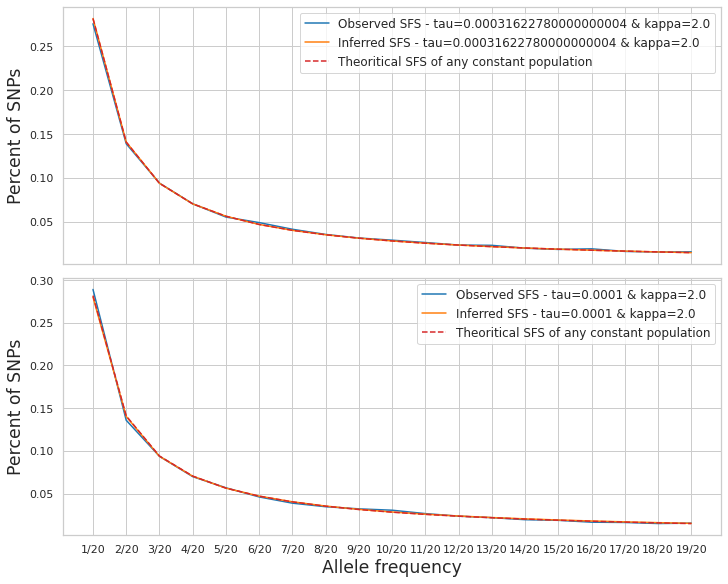

In [37]:
plot_sfs_simulation(data_2)

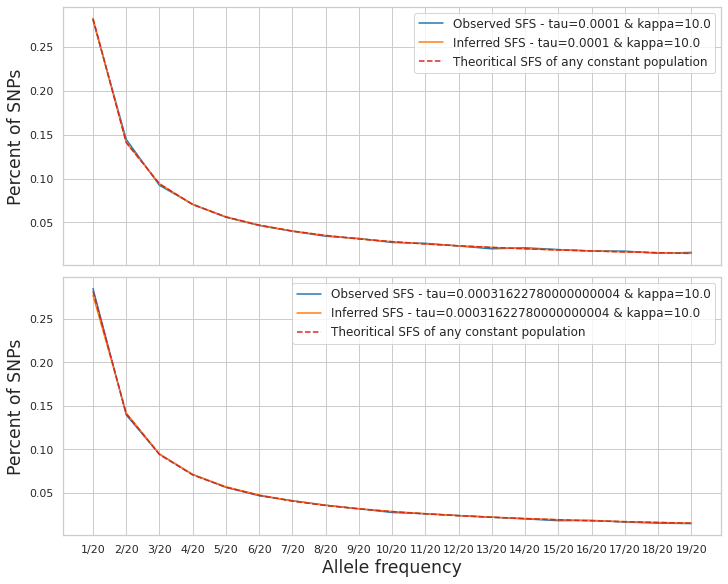

In [38]:
plot_sfs_simulation(data_10)

<br>

> Log-likelihood ratio test

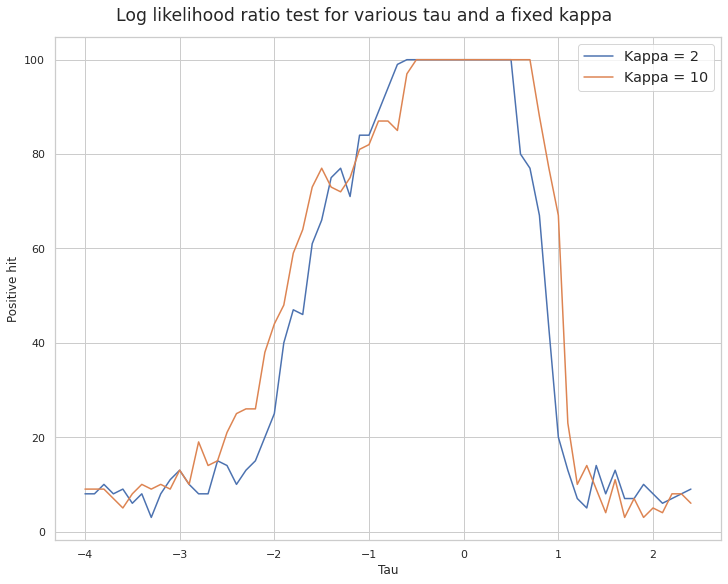

In [28]:
plot_inference_dadi(
    data=[data_2, data_10], key="Tau",
    labels=['Kappa = 2', 'Kappa = 10'],
    suptitle="Log likelihood ratio test for various tau and a fixed kappa")

<br>

### Fixed tau - sudden decline & growth model 

> Load data

In [29]:
data_1 = f.export_inference_files('decline', 'tau', 1)

data_wsd_tau = [data_weighted_square_distance(data_1)]

<br>

> Weighted square distance

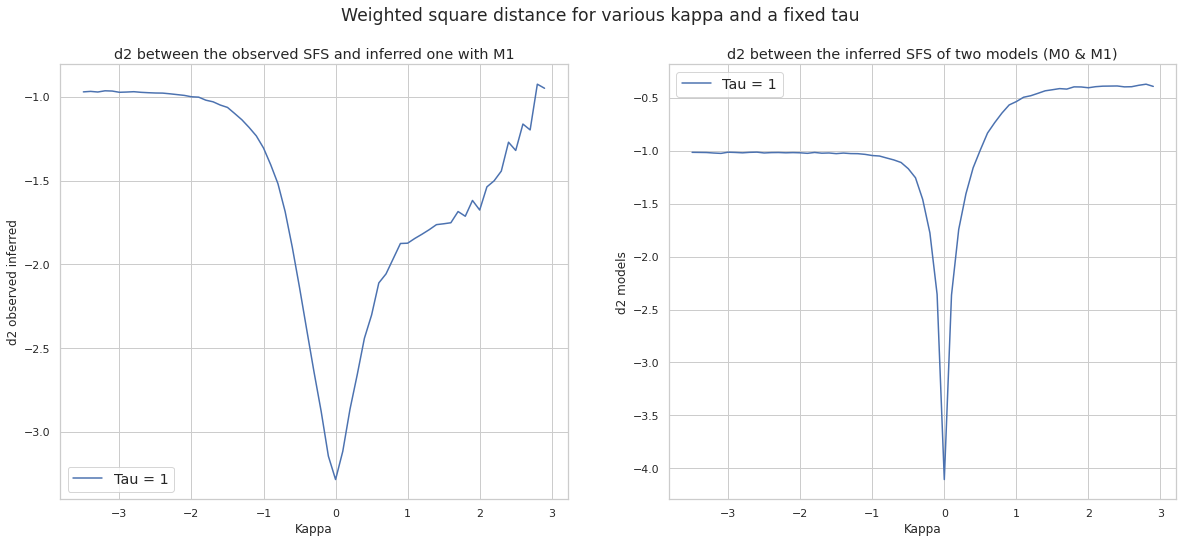

In [30]:
plot_weighted_square_distance(
    data=data_wsd_tau, key="Kappa", 
    labels=['Tau = 1'],
    suptitle="Weighted square distance for various kappa and a fixed tau")

<br>

> Log-likelihood ratio test

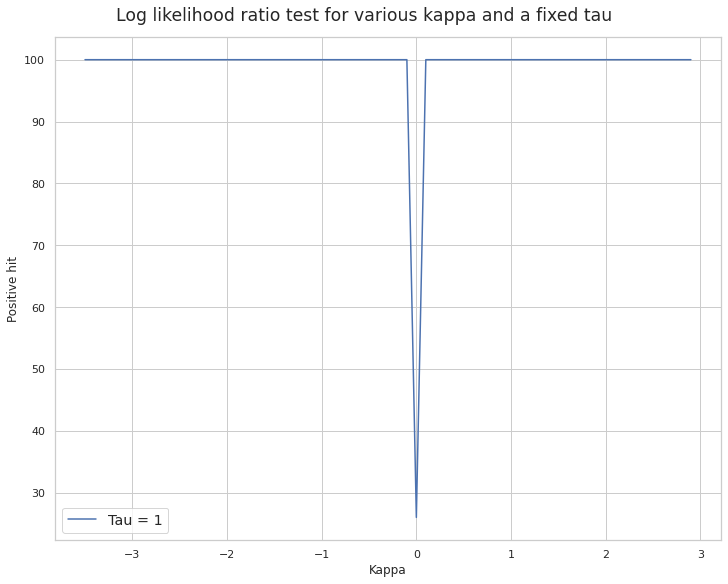

In [31]:
plot_inference_dadi(
    data=[data_1], key="Kappa",
    labels=['Tau = 1'],
    suptitle="Log likelihood ratio test for various kappa and a fixed tau")

<br>

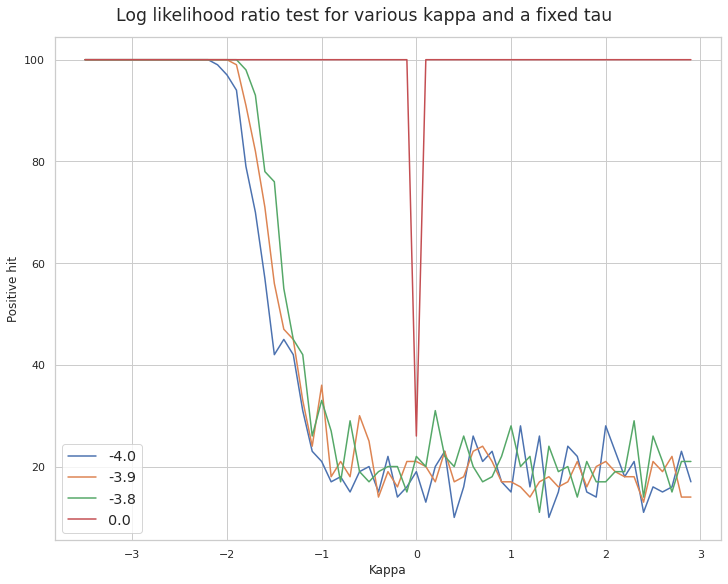

In [33]:
data, labels = [], []
for value in [0.0001, 0.00012589254117941674, 0.00015848931924611142, 1]:
    data.append(f.export_inference_files('decline', 'tau', value))
    labels.append(round(np.log10(value), 2))
    
plot_inference_dadi(
    data=data, key="Kappa",
    labels=labels,
    suptitle="Log likelihood ratio test for various kappa and a fixed tau")